# Hawaii Shark Incident Data Analysis

This analysis focuses on shark incidents in Hawaii. The workflow includes data collection, cleaning, transformation, and visualization to extract meaningful insights.


## 1. Data Collection

Data was collected from the [Hawaii Department of Land and Natural Resources website](https://dlnr.hawaii.gov/sharks/shark-incidents/incidents-list/), which details shark incidents.

In [1]:
import re
import requests
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import unicodedata
import os

# Constants
URL = "https://dlnr.hawaii.gov/sharks/shark-incidents/incidents-list/"
HEADERS = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/124.0.0.0 Safari/537.36',
    'Accept-Language': 'en-US, en;q=0.5'
}

# Fetch the webpage with error handling
try:
    response = requests.get(URL, headers=HEADERS)
    response.raise_for_status()
    soup = BeautifulSoup(response.content, "html.parser")
except requests.exceptions.RequestException as e:
    print(f"Error fetching webpage: {e}")
    raise

# Extract table data
table = soup.find('table')
headers = [th.text.strip() for th in table.find_all('th')]
rows = [[td.text.strip() for td in tr.find_all('td')] for tr in table.find_all('tr')[1:]]
data = pd.DataFrame(rows, columns=headers)

# Create a directory for data
data_dir = 'data'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

data.to_csv(os.path.join(data_dir,'shark_incidents_raw.csv'), index=False, encoding='utf-8')

## 2. Data Cleaning

This section involves cleaning the data by renaming columns, parsing date and time, extracting and normalizing location details, and cleaning textual data.

In [2]:
# Rename columns for clarity
data.columns = ['Date_and_Time', 'Location', 'Activity', 'Water_Clarity', 'Water_Depth_ft', 'Victim', 'Description', 'Shark']

# Parse 'Date and Time'
data[['Date', 'Time']] = data['Date_and_Time'].str.split(',', expand=True)
data['Date'] = pd.to_datetime(data['Date'].str.strip(), errors='coerce')
data['Time'] = pd.to_datetime(data['Time'].str.strip(), format='%I:%M %p', errors='coerce').dt.time

# Extract 'Location' components
location_split = data['Location'].str.split(r'[;,]', expand=True)
data['Island'] = location_split[0].str.strip() if location_split.shape[1] > 0 else None
data['Area'] = location_split[1].str.strip() if location_split.shape[1] > 1 else None
data['Distance_From_Shore'] = location_split[2:].apply(lambda x: ', '.join(x.dropna().str.strip()), axis=1) if location_split.shape[1] > 2 else None

# Function to clean and normalize text
def clean_text(text):
    if isinstance(text, str):
        text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('ascii')
        return text.strip().title()
    return text

# Apply text cleaning to relevant columns
data['Island'] = data['Island'].apply(clean_text)
data['Area'] = data['Area'].apply(clean_text)

## 3. Data Transformation

This section involves transforming the data, including converting text to numeric values, splitting and standardizing data columns, converting measurements to standard units and ensuring consistency in data representation.

In [3]:
# Replace words with corresponding numbers in 'Distance_From_Shore'
WORD_TO_NUM = {
    "one": "1", "two": "2", "three": "3", "four": "4", "five": "5",
    "six": "6", "seven": "7", "eight": "8", "nine": "9", "ten": "10"
}

def replace_words_with_numbers(text: str) -> str:
    if isinstance(text, str):
        for word, num in WORD_TO_NUM.items():
            text = re.sub(rf"\b{word}\b", num, text, flags=re.IGNORECASE)
    return text

data['Distance_From_Shore'] = data['Distance_From_Shore'].apply(replace_words_with_numbers)

# Split 'Description' into 'Injury' and 'Details'
def split_description(desc: str) -> tuple:
    desc_lower = desc.strip().lower()
    if 'fatal' in desc_lower:
        main_desc = "Fatal"
        details = desc[desc_lower.find('fatal') + len('fatal'):].strip()
    elif 'no injury' in desc_lower:
        main_desc = "No Injury"
        details = desc[desc_lower.find('no injury') + len('no injury'):].strip()
    else:
        main_desc = "Injury"
        details = desc.strip()
    details = details.lstrip(';. ')
    return main_desc, details.title()

data[['Injury', 'Details']] = data['Description'].apply(split_description).apply(pd.Series)

# Standardize 'Water Depth'
data['Water_Depth_ft'] = data['Water_Depth_ft'].str.replace('est ', '').str.replace('ft', '').str.strip()
data['Water_Depth_ft'] = pd.to_numeric(data['Water_Depth_ft'], errors='coerce')

# Process 'Shark' information
shark_info_split = data['Shark'].str.split(',', expand=True)
data['Shark_Species'] = shark_info_split[0].str.strip().str.title()
data['Shark_Length_ft'] = shark_info_split[1].str.replace('length', '').str.strip() if shark_info_split.shape[1] > 1 else None
data['Shark_Species'] = data['Shark_Species'].apply(lambda x: 'Unknown' if 'unknown' in x.lower() else x)

# Mapping for specific activities to standard terms
activity_mapping = {
    'Fishing From Kayak': 'Fishing',
    'Fishing From Surfboard': 'Fishing',
    'Surfing - Kite': 'Surfing',
    'Surfing - Wind': 'Surfing',
    'Swimming With Sharks': 'Swimming',
    'Treading Water': 'Swimming'
}

# Apply mapping to 'Activity' column
data['Activity'] = data['Activity'].apply(clean_text).replace(activity_mapping)

# Define a function to clean and standardize shark length to feet.
def clean_and_average_shark_length(length: str) -> float:
    """Clean and standardize shark length to feet."""
    if pd.isna(length):
        return None
    numbers = re.findall(r'\d+\.?\d*', length)
    if not numbers:
        return None
    value = (float(numbers[0]) + float(numbers[1])) / 2 if len(numbers) == 2 else float(numbers[0])
    length_lower = length.lower()
    if 'meter' in length_lower or 'm' in length_lower:
        return value * 3.28084
    elif 'yard' in length_lower or 'yd' in length_lower:
        return value * 3
    elif 'centimeter' in length_lower or 'cm' in length_lower:
        return value * 0.0328084
    elif 'inch' in length_lower or 'in' in length_lower:
        return value / 12
    else:
        return value

data['Shark_Length_ft'] = data['Shark_Length_ft'].apply(clean_and_average_shark_length).round(2)

# Define a function to convert various distance units to yards.
def convert_to_yards(distance: str) -> float:
    """Convert various distance units to yards."""
    if pd.isna(distance):
        return None
    distance = distance.lower()
    numbers = re.findall(r'\d+\.?\d*', distance)
    if not numbers:
        return None
    value = (float(numbers[0]) + float(numbers[1])) / 2 if len(numbers) == 2 else float(numbers[0])
    if 'mile' in distance:
        return value * 1760
    elif 'yard' in distance or 'yd' in distance:
        return value
    elif 'foot' in distance or 'feet' in distance or 'ft' in distance:
        return value / 3
    else:
        return value

data['Distance_From_Shore_y'] = data['Distance_From_Shore'].apply(convert_to_yards).round(2)

# Select relevant columns for final analysis and export cleaned data
columns_to_keep = [
    'Activity', 'Water_Clarity', 'Water_Depth_ft', 'Victim', 
    'Date', 'Time', 'Island', 'Area', 'Shark_Species', 
    'Injury', 'Shark_Length_ft', 'Details', 'Distance_From_Shore_y'
]

data = data[columns_to_keep]

# Export the cleaned data to a CSV file.
data.to_csv(os.path.join(data_dir,'shark_incidents_cleaned.csv'), index=False, encoding='utf-8')

# Display the final DataFrame
data.head()

,Activity,Water_Clarity,Water_Depth_ft,Victim,Date,Time,Island,Area,Shark_Species,Injury,Shark_Length_ft,Details,Distance_From_Shore_y
0,Surfing,Turbid,NaN,T. Perry,2024-06-24,NaT,Oahu,Laie,Unknown,Fatal,NaN,"Loss Of Right Forearm, Severe Lacerations To R...",NaN
1,Swimming,Clear,600.0,Confidential,2024-06-07,13:40:00,Oahu,Haleiwa,Unknown,Injury,NaN,"Lacerations To Right Thigh, Forearm, And Hand....",NaN
2,Surfing,Turbid,NaN,M. White,2024-03-04,16:55:00,Oahu,Waikiki,Tiger Shark,No Injury,9.00,Shark Bit Tail Of Surfboard.,350.0
3,Swimming,Turbid,NaN,Confidential,2024-03-02,13:25:00,Oahu,Kaaawa,Unknown,Injury,9.84,Lacerations To Left Foot.,2.5
4,Surfing,Turbid,NaN,J. Carter,2023-12-30,11:10:00,Maui,Paia Bay,Unknown,Fatal,9.00,Loss Of Left Leg.,150.0


## 4. Data Visualization

This section demonstrates visualizations to uncover trends and insights in the cleaned shark incident data.

### 4.1 Incident Count by Year
- Visualize the number of incidents over the years to see if there is an increasing or decreasing trend.

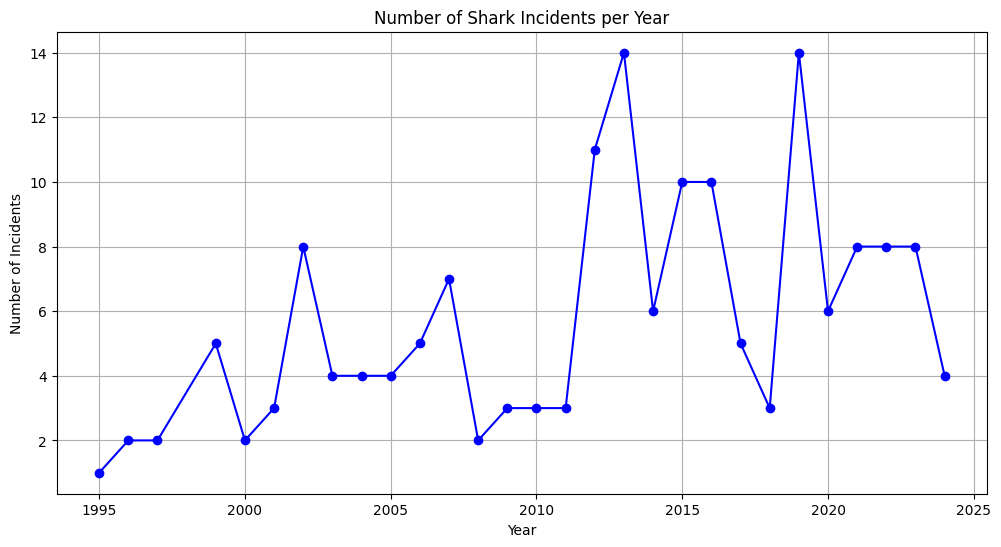

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a directory for graph images
image_dir = 'images'
if not os.path.exists(image_dir):
    os.makedirs(image_dir)

# Extract year from the 'Date' column
data['Year'] = data['Date'].dt.year

# Count incidents per year
incident_counts = data['Year'].value_counts().sort_index()

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(incident_counts.index, incident_counts.values, marker='o', linestyle='-', color='b')
plt.title('Number of Shark Incidents per Year')
plt.xlabel('Year')
plt.ylabel('Number of Incidents')
plt.grid(True)
plt.savefig(os.path.join(image_dir,'incidents_per_year.png'))
plt.show()

### 4.2 Incidents by Activity
- Display the distribution of shark incidents by activity to see which activities are more associated with shark encounters.

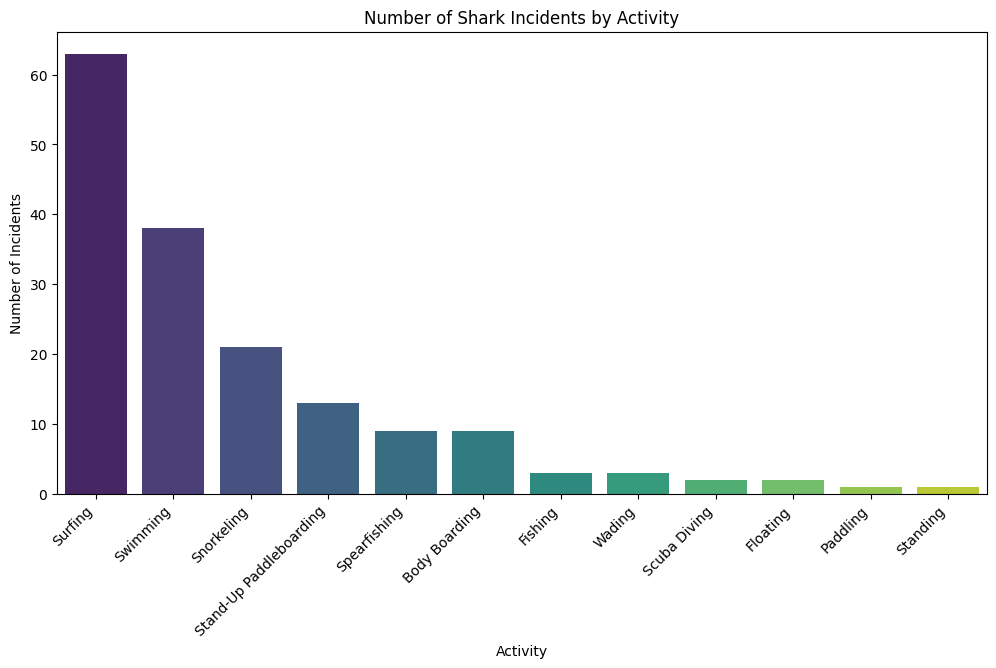

In [5]:
# Count incidents by activity
activity_counts = data['Activity'].value_counts().reset_index()
activity_counts.columns = ['Activity', 'Count']

plt.figure(figsize=(12, 6))
sns.barplot(x='Activity', y='Count', hue='Activity', data=activity_counts, palette='viridis', dodge=False)
plt.title('Number of Shark Incidents by Activity')
plt.xlabel('Activity')
plt.ylabel('Number of Incidents')
plt.xticks(rotation=45, ha='right')
plt.legend([],[], frameon=False)
plt.savefig(os.path.join(image_dir, 'activity_distribution.png'))
plt.show()

### 4.3 Injury Severity Distribution
- Visualize the distribution of injury severities reported in shark incidents.

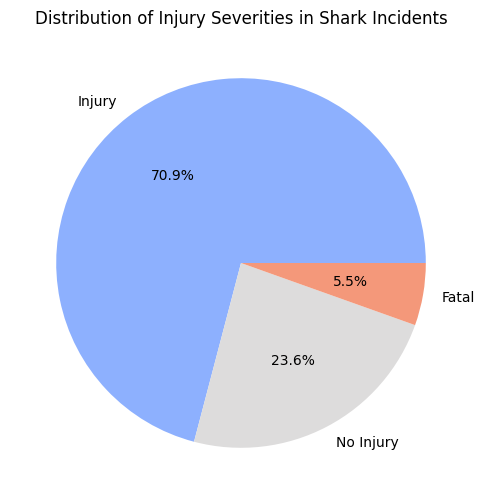

In [6]:
# Calculate the percentage of each injury severity
injury_counts = data['Injury'].value_counts(normalize=True).reset_index()
injury_counts.columns = ['Injury', 'Percentage']
injury_counts['Percentage'] *= 100  # Convert to percentage

# Plotting the pie chart
plt.figure(figsize=(6, 6))
plt.pie(injury_counts['Percentage'], labels=injury_counts['Injury'], autopct='%1.1f%%', colors=sns.color_palette('coolwarm', len(injury_counts)))
plt.title('Distribution of Injury Severities in Shark Incidents')
plt.savefig(os.path.join(image_dir, 'injury_distribution.png'))
plt.show()

### 4.4 Shark Species Involved in Incidents
- Display the frequency of different shark species involved in incidents.

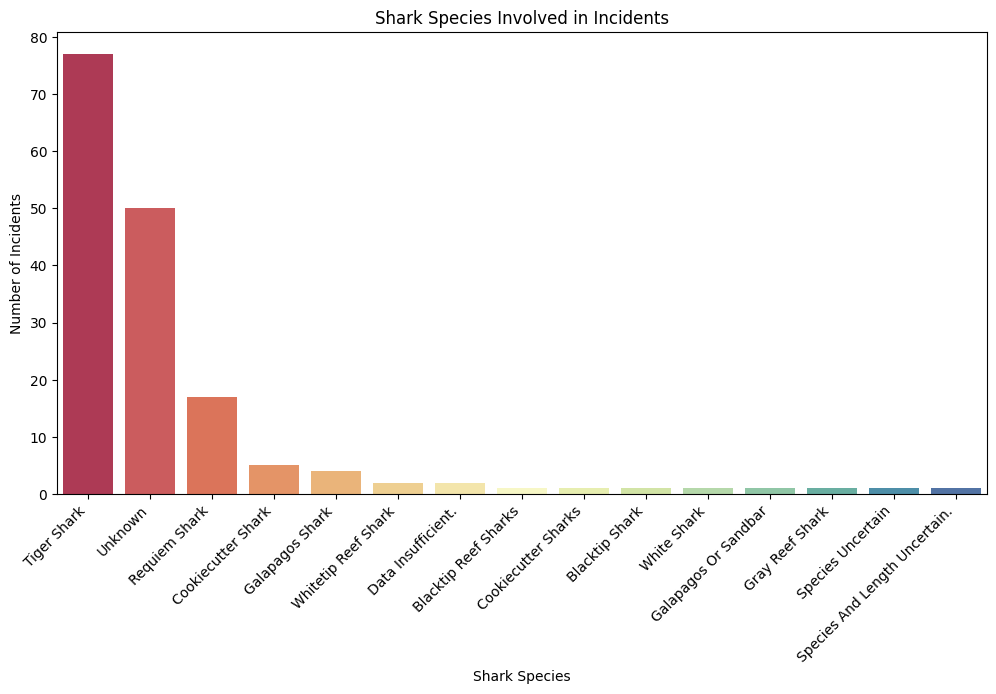

In [7]:
# Count incidents by shark species
species_counts = data['Shark_Species'].value_counts().reset_index()
species_counts.columns = ['Shark_Species', 'Count']

plt.figure(figsize=(12, 6))
sns.barplot(x='Shark_Species', y='Count', hue='Shark_Species', data=species_counts, palette='Spectral', dodge=False)
plt.title('Shark Species Involved in Incidents')
plt.xlabel('Shark Species')
plt.ylabel('Number of Incidents')
plt.xticks(rotation=45, ha='right')
plt.legend([], [], frameon=False)
plt.savefig(os.path.join(image_dir, 'shark_species.png'))
plt.show()

### 4.5 Incident Locations by Island
- Show the distribution of incidents across different islands.

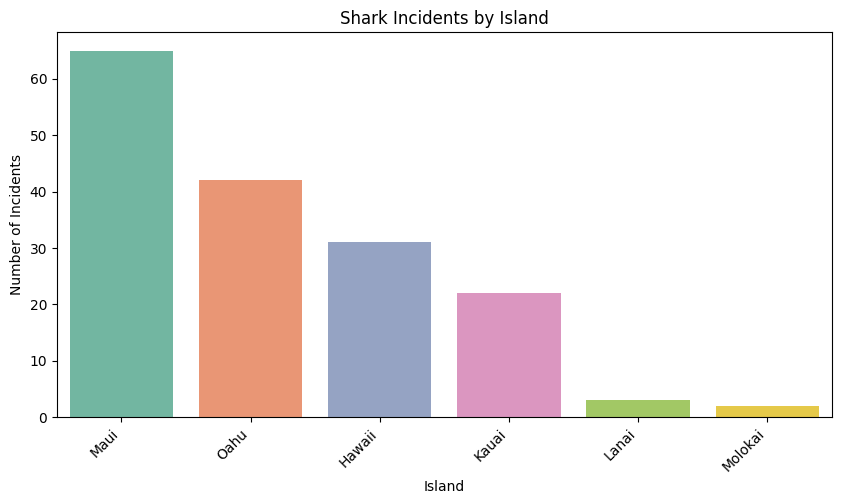

In [8]:
# Count incidents by island
island_counts = data['Island'].value_counts().reset_index()
island_counts.columns = ['Island', 'Count']

plt.figure(figsize=(10, 5))
sns.barplot(x='Island', y='Count', hue='Island', data=island_counts, palette='Set2', dodge=False)
plt.title('Shark Incidents by Island')
plt.xlabel('Island')
plt.ylabel('Number of Incidents')
plt.xticks(rotation=45, ha='right')
plt.legend([], [], frameon=False) 
plt.savefig(os.path.join(image_dir, 'incidents_by_island.png'))
plt.show()

### 4.6 Distance from Shore
- Visualize the distribution of distances from shore where incidents occurred.

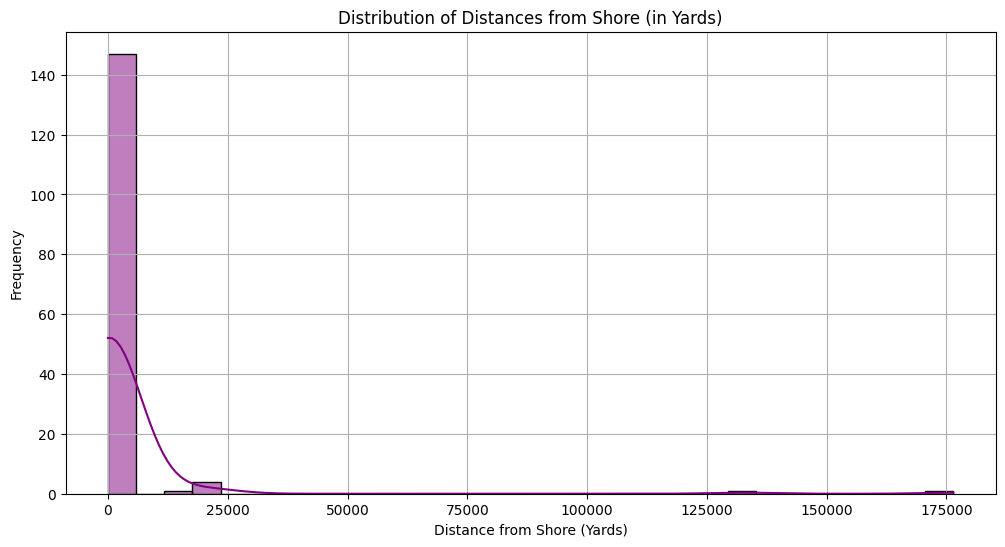

In [9]:
# Plotting
plt.figure(figsize=(12, 6))
sns.histplot(data['Distance_From_Shore_y'].dropna(), bins=30, kde=True, color='purple')
plt.title('Distribution of Distances from Shore (in Yards)')
plt.xlabel('Distance from Shore (Yards)')
plt.ylabel('Frequency')
plt.grid(True)
plt.savefig(os.path.join(image_dir, 'distance_from_shore.png'))
plt.show()

### 4.7 Heatmap of Incidents by Month and Year
- A heatmap can show the density of incidents across different months and years.

NameError: name 'output_dir' is not defined

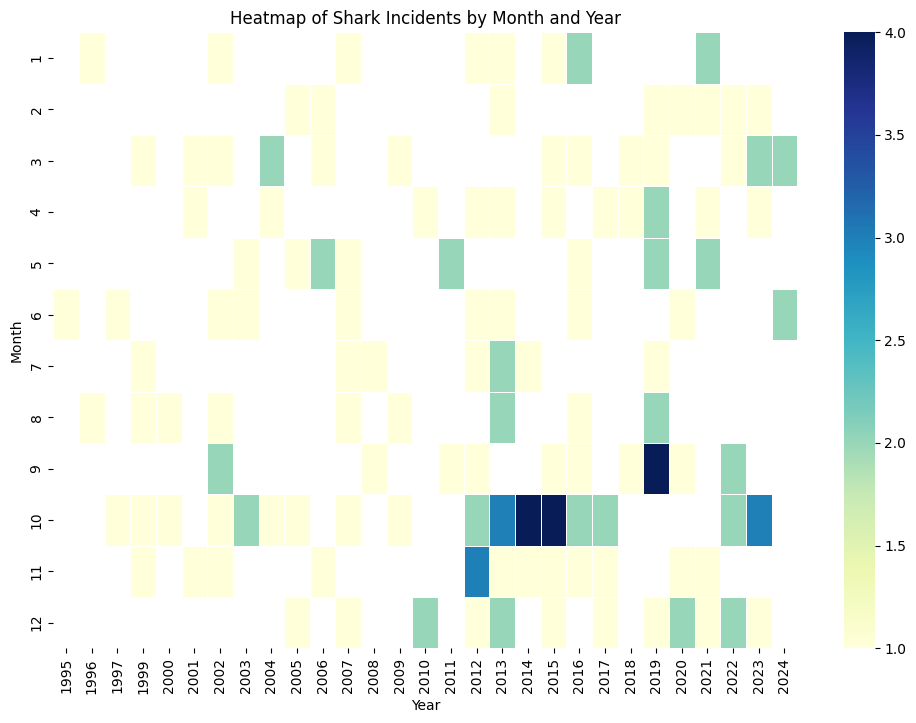

In [10]:
# Extract month from the 'Date' column
data['Month'] = data['Date'].dt.month

# Create a pivot table for the heatmap
heatmap_data = data.pivot_table(index='Month', columns='Year', values='Activity', aggfunc='count')

# Plotting
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='YlGnBu', linewidths=.5)
plt.title('Heatmap of Shark Incidents by Month and Year')
plt.xlabel('Year')
plt.ylabel('Month')
plt.savefig(os.path.join(image_dir, 'heatmap.png'), dpi=300, bbox_inches='tight')
plt.show()

## 5. Insights and Conclusions

- Incidents Over Time: There were notable upticks in shark incidents in the years **2013 and 2019**, suggesting periodic increases in shark activity or human encounters.

- Activity Risk: **Surfing** and **swimming** were the activities most frequently associated with shark incidents, indicating a higher risk for participants.

- Injury Severity: Approximately **5.5%** of the shark incidents were **fatal**, highlighting the potential severity of these encounters.

- Shark Species Involvement: Most incidents were associated with **Tiger Sharks**, emphasizing the need for targeted awareness and safety measures regarding this species.

- Geographic Distribution: The island of **Maui** experienced the highest frequency of incidents, suggesting a possible hotspot for shark activity.

-  Monthly Trends: **October** had the highest frequency of shark incidents, followed by **September**, suggesting a seasonal pattern in shark encounters.